In [1]:
# Author: Arthur Prigent
# Email: aprigent@ictp.it

In [2]:
from load_librairies import *
from scipy.stats.stats import pearsonr
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy
import matplotlib.transforms as transforms

def nandetrend(y):
    ''' Remove the linear trend from the data '''
    
    x = np.arange(0,y.shape[0],1)
    m, b, r_val, p_val, std_err = stats.linregress(x,np.array(y))
    y_detrended= np.array(y) - m*x
    return y_detrended

def is_jja(month):
    return (month>=6) & (month<=8)

def is_mjj(month):
    return (month>=5) & (month<=7)
def is_amj(month):
    return (month>=4) & (month<=6)

def is_mam(month):
    return (month>=3) & (month<=5)
def is_nd(month):
    return (month==11) | (month==12)


dir_proj = '/home/netapp-clima-users/users/aprigent/Projects/TAV_OMIP/'
path_fig = dir_proj+'/figures_final/'
path_data_out = '/media/aprigent/Arthur_disk/data_uncertainty/'
dir_oras5 = '/home/netapp-clima-users/users/aprigent/Observations/ORA-S5/'


data_oras5 = '/media/aprigent/Arthur_disk/Data/ORA-S5/'
dir_thetao_omip1 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/thetao/mon/'
#dir_tos_omip2 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/thetao/mon/'
#dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/HadI-SST/'
dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/'

period_str = 1985
period_end = 2004
%matplotlib inline

/tmp/ipykernel_15784/236295515.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Load model lists

In [3]:
omip1_models = pd.read_csv(dir_proj+'/scripts/omip1_models_for_BF_zos.txt',header=None,delimiter=',')
omip1_models = omip1_models[0].values.tolist()
print(omip1_models)



omip2_models = pd.read_csv(dir_proj+'/scripts/omip2_models_for_BF_zos.txt',header=None,delimiter=',')
omip2_models = omip2_models[0].values.tolist()
print(omip2_models)

['CMCC-CM2-SR5', 'CMCC-ESM2', 'EC-Earth3', 'IPSL-CM6A-LR', 'MRI-ESM2-0', 'NorESM2-LM']
['ACCESS-OM2', 'ACCESS-OM2-025', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'EC-Earth3', 'MRI-ESM2-0', 'NorESM2-LM']


# Load data 


# AVISO

In [4]:
ssh_aviso_atl3 = xr.open_dataset(dir_obs_sst+'AVISO/sla_cmems_1993_2004_atl3_mean.nc')
ssh_aviso_atl3_dtd = ssh_aviso_atl3.assign_coords(sla_dtd=('time',  nandetrend(ssh_aviso_atl3.sla[:,0,0])))
ssha_aviso_atl3_dtd,_ = Atools.ano_norm_t(ssh_aviso_atl3_dtd.sla_dtd)

In [5]:
std_aviso_atl3_seasonal_cycle = ssha_aviso_atl3_dtd.groupby('time.month').std()


ssha_aviso_atl3_dtd_mjj = ssha_aviso_atl3_dtd.sel(
    time=is_mjj(ssha_aviso_atl3_dtd['time.month'])).groupby('time.year').mean()
std_ssha_aviso_atl3_dtd_mjj = ssha_aviso_atl3_dtd_mjj.std(dim='year')


# HadI-SST

In [6]:
sst_hd_tmp = xr.open_dataset('/home/esp-shared-a/Observations/SST/HadISST/HadISST_sst.nc')
sst_hd_tmp = sst_hd_tmp.sst[:]
sst_hd = sst_hd_tmp.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
sst_hd_arr = np.array(sst_hd)
sst_hd_atl_dtd = np.ones((sst_hd_arr.shape))*np.nan
for i in range(sst_hd_atl_dtd.shape[1]):
    for j in range(sst_hd_atl_dtd.shape[2]):
        sst_hd_atl_dtd[:,i,j] = nandetrend(sst_hd_arr[:,i,j])
        
sst_hd_atl_dtd_xarray  = xr.Dataset({'sst_dtd': (['time','lat','lon'],sst_hd_atl_dtd)}
                       ,coords={'time':np.array(sst_hd.time),
                                'lon':np.array(sst_hd.lon),
                                'lat':np.array(sst_hd.lat)
                                })
sst_hd_atl_dtd_xarray_atl3 = Atools.data_sub(sst_hd_atl_dtd_xarray,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(sst_hd_atl_dtd_xarray,-20,0,-3,3).lat))).mean(('lon','lat'))
ssta_hd_atl3_dtd,_ = Atools.ano_norm_t(sst_hd_atl_dtd_xarray_atl3.sst_dtd)



ssta_hd_atl3_dtd_mjj = ssta_hd_atl3_dtd.sel(
    time=is_mjj(ssta_hd_atl3_dtd['time.month'])).groupby('time.year').mean()
std_ssta_hd_atl3_dtd_mjj = ssta_hd_atl3_dtd_mjj.std(dim='year')

/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/xarray/coding/times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


# ORA-S5

In [7]:
## ssh ##


zos_oras5 = xr.open_mfdataset(dir_oras5+'sossheig_merged_r360x180_oras5_1984_2005.nc',use_cftime=True)
zos_oras5_atl3 = Atools.data_sub(zos_oras5.sossheig,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(zos_oras5,-40,-20,-3,3).lat))).mean(('lon','lat'))
zos_oras5_atl3_dtd = zos_oras5_atl3.assign_coords(zos_dtd=('time_counter',  nandetrend(zos_oras5_atl3)))
zosa_oras5_atl3_dtd,_ = Atools.ano_norm_tc(zos_oras5_atl3_dtd.zos_dtd)

zosa_oras5_atl3_dtd_mjj = zosa_oras5_atl3_dtd.sel(
    time_counter=is_mjj(zosa_oras5_atl3_dtd['time_counter.month'])).groupby('time_counter.year').mean()
std_zosa_oras5_atl3_dtd_mjj = zosa_oras5_atl3_dtd_mjj.std(dim='year')


## uas ##
uas_oras5 = xr.open_mfdataset(dir_oras5+'sozotaux_merged_r360x180_oras5_1984_2005.nc',use_cftime=True)
uas_oras5_atl4 = Atools.data_sub(uas_oras5.sozotaux,-40,-20,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(uas_oras5,-40,-20,-3,3).lat))).mean(('lon','lat'))
uas_oras5_atl4_dtd = uas_oras5_atl4.assign_coords(uas_dtd=('time_counter',  nandetrend(uas_oras5_atl4)))
uasa_oras5_atl4_dtd,_ = Atools.ano_norm_tc(uas_oras5_atl4_dtd.uas_dtd)

uasa_oras5_atl4_dtd_mjj = uasa_oras5_atl4_dtd.sel(
    time_counter=is_amj(uasa_oras5_atl4_dtd['time_counter.month'])).groupby('time_counter.year').mean()
std_uasa_oras5_atl4_dtd_mjj = uasa_oras5_atl4_dtd_mjj.std(dim='year')

## thetao ##
thetao_eq_oras5 = xr.open_dataset(path_data_out+'temp_oras5_eq_1985_2004.nc')
thetao_af_oras5 = xr.open_dataset(path_data_out+'temp_oras5_af_1985_2004.nc')
thetaoa_eq_oras5_mjj = thetao_eq_oras5.tempa.sel(
    time=is_mjj(thetao_eq_oras5.tempa['time.month'])).groupby('time.year').mean()

std_thetaoa_eq_oras5_mjj = thetaoa_eq_oras5_mjj.std(dim='year')


## dT/dz ##
dtdz_eq_oras5 = xr.open_dataset(path_data_out+'dtdz_oras5_eq_1985_2004_newtest.nc')
dtdz_af_oras5 = xr.open_dataset(path_data_out+'dtdz_oras5_af_1985_2004.nc')
dtdz_eq_oras5_mjj = dtdz_eq_oras5.dtdz.sel(time=is_mjj(dtdz_eq_oras5.dtdz['time.month'])).mean(dim='time')

dtdz_max_eq_oras5_mjj = dtdz_eq_oras5.dtdz_max.sel(time=is_mjj(
    dtdz_eq_oras5.dtdz_max['time.month'])).mean(dim='time')

## sst ##

sst_oras5_tmp = xr.open_dataset(dir_obs_sst+'ORA-S5/sosstsst_merged_r360x180_oras5_1984_2005.nc')
sst_oras5_tmp = sst_oras5_tmp.sosstsst[:] # K to degC
sst_oras5 = sst_oras5_tmp.sel(time_counter=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
sst_oras5_arr = np.array(sst_oras5)
sst_oras5_atl_dtd = np.ones((sst_oras5_arr.shape))*np.nan
for i in range(sst_oras5_atl_dtd.shape[1]):
    for j in range(sst_oras5_atl_dtd.shape[2]):
        sst_oras5_atl_dtd[:,i,j] = nandetrend(sst_oras5_arr[:,i,j])
        
        
sst_oras5_atl_dtd_xarray  = xr.Dataset({'sst_dtd': (['time','lat','lon'],sst_oras5_atl_dtd)}
                       ,coords={'time':np.array(sst_oras5.time_counter),
                                'lon':np.array(sst_oras5.lon),
                                'lat':np.array(sst_oras5.lat)
                                })
        


ssta_oras5_atl_dtd,_ = Atools.ano_norm_t(sst_oras5_atl_dtd_xarray.sst_dtd)
ssta_oras5_atl3_dtd = Atools.data_sub(ssta_oras5_atl_dtd,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(ssta_oras5_atl_dtd,-20,0,-3,3).lat))).mean(('lon','lat'))


ssta_oras5_atl3_dtd_mjj = ssta_oras5_atl3_dtd.sel(time=is_mjj(
    ssta_oras5_atl3_dtd['time.month'])).groupby('time.year').mean()
std_ssta_oras5_atl3_dtd_mjj = ssta_oras5_atl3_dtd_mjj.std(dim='year')

### Compute dT/dz max tilt

In [8]:
dtdz_max_eq_oras5_mjj_atl4 = dtdz_max_eq_oras5_mjj.where((dtdz_max_eq_oras5_mjj.lon<-20)&
                                                         (dtdz_max_eq_oras5_mjj.lon>-40)).mean(dim='lon')

dtdz_max_eq_oras5_mjj_atl3 = dtdz_max_eq_oras5_mjj.where((dtdz_max_eq_oras5_mjj.lon<0)&
                                                         (dtdz_max_eq_oras5_mjj.lon>-20)).mean(dim='lon')

dtdz_max_eq_oras5_mjj_tilt = dtdz_max_eq_oras5_mjj_atl4 - dtdz_max_eq_oras5_mjj_atl3

### Compute amplitude of the dT/dz +/- 10 m around the dT/dz max

In [9]:
dtdz_eq_oras5_mjj_dtdzmax_mean_atl3 = dtdz_eq_oras5_mjj.where((dtdz_eq_oras5_mjj.lon<0)&
                                                         (dtdz_eq_oras5_mjj.lon>-20)&
                                                         (dtdz_eq_oras5_mjj.depth<dtdz_max_eq_oras5_mjj+10) &
                                                         (dtdz_eq_oras5_mjj.depth>dtdz_max_eq_oras5_mjj-10))

dtdz_eq_oras5_mjj_dtdzmax_mean_atl3_mean = dtdz_eq_oras5_mjj_dtdzmax_mean_atl3.mean(dim='lon').mean(dim='depth')



std_thetaoa_eq_oras5_mjj_mean_atl3 = std_thetaoa_eq_oras5_mjj.where((std_thetaoa_eq_oras5_mjj.lon<0)&
                                                         (std_thetaoa_eq_oras5_mjj.lon>-20)&
                                                         (std_thetaoa_eq_oras5_mjj.depth<dtdz_max_eq_oras5_mjj+10) &
                                                         (std_thetaoa_eq_oras5_mjj.depth>dtdz_max_eq_oras5_mjj-10))

std_thetaoa_eq_oras5_mjj_mean_atl3_mean = std_thetaoa_eq_oras5_mjj_mean_atl3.mean(dim='lon').mean(dim='depth')




In [11]:
dtdz_max_eq_oras5_mjj_atl3 = dtdz_max_eq_oras5_mjj.where(dtdz_max_eq_oras5_mjj.lon>-20 &
                                                         (dtdz_max_eq_oras5_mjj.lon<0))

dtdz_max_eq_oras5_mjj_atl3_mean = dtdz_max_eq_oras5_mjj_atl3.mean(dim='lon')



In [12]:
bf3_oras5 = xr.open_dataset(path_data_out+'BF3_oras5_atl_1985_2004_new_mjj.nc')


# OMIP1 and OMIP2 data
- TAV_OMIP/scripts/processing/prepare_temperature_eq_omip1.ipynb
- TAV_OMIP/scripts/processing/prepare_temperature_eq_omip2.ipynb
- TAV_OMIP/scripts/processing/prepare_BF3_omip1.ipynb
- TAV_OMIP/scripts/processing/prepare_BF3_omip2.ipynb
- TAV_OMIP/scripts/processing/prepare_dTdz_eq_omip1.ipynb
- TAV_OMIP/scripts/processing/prepare_dTdz_eq_omip2.ipynb
- TAV_OMIP/scripts/processing/prepare_mld_eq_omip1.ipynb
- TAV_OMIP/scripts/processing/prepare_mld_eq_omip2.ipynb
- TAV_OMIP/scripts/processing/prepare_tauuo_omip1.ipynb
- TAV_OMIP/scripts/processing/prepare_tauuo_omip2.ipynb
- TAV_OMIP/scripts/processing/prepare_zos_omip1.ipynb
- TAV_OMIP/scripts/processing/prepare_zos_omip2.ipynb

In [13]:
## temp ##
thetao_eq_omip1 = xr.open_dataset(path_data_out+'temp_omip1_eq_1985_2004_new.nc')
thetao_eq_omip2 = xr.open_dataset(path_data_out+'temp_omip2_eq_1985_2004.nc')

## dtdz ##
dtdz_eq_omip1 = xr.open_dataset(path_data_out+'dtdz_eq_omip1_1985_2004_newtest_new.nc')
dtdz_eq_omip2 = xr.open_dataset(path_data_out+'dtdz_eq_omip2_1985_2004_newtest.nc')

## SST ##
ssta_omip1_atl_all = xr.open_dataset(path_data_out+'sst_ssta_omip1_atl_1985_2004_cycle5.nc')
ssta_omip2_atl_all = xr.open_dataset(path_data_out+'sst_ssta_omip2_atl_1985_2004.nc')

## BF3 ##
bf3_omip1 = xr.open_dataset(path_data_out+'BF3_omip1_atl_1985_2004_new_mjj_cycle5.nc')
bf3_omip2 = xr.open_dataset(path_data_out+'BF3_omip2_atl_1985_2004_new_mjj.nc')

## MLD ##
mld_eq_omip1 = xr.open_dataset(path_data_out+'mld_omip1_eq_1985_2004_cycle5.nc')
mld_eq_omip2 = xr.open_dataset(path_data_out+'mld_omip2_eq_1985_2004.nc')

## mean equatorial UAS ##
uas_eq_omip1 = xr.open_dataset(path_data_out+'uas_omip1_eq_1985_2004_cycle5.nc')
uas_eq_omip2 = xr.open_dataset(path_data_out+'uas_omip2_eq_1985_2004.nc')

## ZOS ##
zos_eq_omip1 = xr.open_dataset(path_data_out+'zos_omip1_atl_1985_2004_cycle5.nc')
zos_eq_omip2 = xr.open_dataset(path_data_out+'zos_omip2_atl_1985_2004.nc')


In [14]:
ssta_omip1_atl3_for_oras5 = Atools.data_sub(ssta_omip1_atl_all,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(ssta_omip1_atl_all,-20,0,-3,3).lat))).mean(('lon','lat'))


ssta_omip2_atl3_for_oras5 = Atools.data_sub(ssta_omip2_atl_all,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(ssta_omip2_atl_all,-20,0,-3,3).lat))).mean(('lon','lat'))



In [15]:
correlation_atl3_sst_aviso_OMIP1 = np.ones((6))*np.nan 
correlation_atl3_sst_aviso_OMIP2 = np.ones((6))*np.nan 

for i in range(correlation_atl3_sst_aviso_OMIP1.shape[0]):
    correlation_atl3_sst_aviso_OMIP1[i] = pearsonr(ssta_oras5_atl3_dtd,ssta_omip1_atl3_for_oras5.ssta[i,:])[0]
    correlation_atl3_sst_aviso_OMIP2[i] = pearsonr(ssta_oras5_atl3_dtd,ssta_omip2_atl3_for_oras5.ssta[i,:])[0]

In [16]:
print(np.round(np.nanmean(correlation_atl3_sst_aviso_OMIP1),2),
      '+/-',np.round(np.nanstd(correlation_atl3_sst_aviso_OMIP1),2))
print(np.round(np.nanmean(correlation_atl3_sst_aviso_OMIP2),2),
      '+/-',np.round(np.nanstd(correlation_atl3_sst_aviso_OMIP2),2))

0.84 +/- 0.02
0.86 +/- 0.02


# MOM1, MOM1-winds, MOM1-heat, MOM025
- TAV_OMIP/scripts/processing/prepare_dTdz_eq_mom.ipynb
- TAV_OMIP/scripts/processing/prepare_tauuo_mom.ipynb
- TAV_OMIP/scripts/processing/prepare_temperature_eq_MOM_JR55.ipynb
- TAV_OMIP/scripts/processing/prepare_tos_mom.ipynb
- TAV_OMIP/scripts/processing/prepare_zos_mom.ipynb
- TAV_OMIP/scripts/processing/prepare_tos_mom_CORE2_winds.ipynb
- TAV_OMIP/scripts/processing/prepare_tauuo_mom_CORE2_winds.ipynb
- TAV_OMIP/scripts/processing/prepare_zos_mom_CORE2_winds.ipynb


- TAV_OMIP/scripts/processing/prepare_tos_mom_CORE2_heat.ipynb
- TAV_OMIP/scripts/processing/prepare_tauuo_mom_CORE2_heat.ipynb
- TAV_OMIP/scripts/processing/prepare_zos_mom_CORE2_heat.ipynb

- TAV_OMIP/scripts/processing/prepare_dTdz_eq_mom025.ipynb
- TAV_OMIP/scripts/processing/prepare_temperature_eq_MOM025_JRA55.ipynb

In [17]:
## SST ##
ssta_mom_atl = xr.open_dataset(path_data_out+'tos_mom_eq_1985_2004.nc')
ssha_mom_atl = xr.open_dataset(path_data_out+'zos_mom_eq_1985_2004.nc')
tauxa_mom_atl = xr.open_dataset(path_data_out+'taux_mom_eq_1985_2004.nc')
dtdz_mom_atl = xr.open_dataset(path_data_out+'dtdz_mom_eq_1985_2004_newtest.nc')
tempa_eq_all = xr.open_dataset(path_data_out+'temp_mom_JRA55_eq_1985_2004.nc')
mld_eq_mom = xr.open_dataset(path_data_out+'mld_mom_JRA55_eq_1985_2004.nc')


tauxa_mom_core2_atl = xr.open_dataset(path_data_out+'taux_mom_core2_eq_1985_2004.nc')
ssta_mom_core2_atl = xr.open_dataset(path_data_out+'tos_mom_core2_eq_1985_2004.nc')
ssha_mom_core2_atl = xr.open_dataset(path_data_out+'zos_mom_core2_eq_1985_2004.nc')
dtdz_mom_core2_atl = xr.open_dataset(path_data_out+'dtdz_mom_core2_eq_1985_2004_newtest.nc')
tempa_mom_core2_eq_all = xr.open_dataset(path_data_out+'temp_mom_JRA55_core2_eq_1985_2004.nc')
mld_eq_mom_core2 = xr.open_dataset(path_data_out+'mld_mom_JRA55_core2_eq_1985_2004.nc')



tauxa_mom_core2_heat_atl = xr.open_dataset(path_data_out+'taux_mom_core2_heat_eq_1985_2004.nc')
ssta_mom_core2_heat_atl = xr.open_dataset(path_data_out+'tos_mom_core2_heat_atl_1985_2004.nc')
ssha_mom_core2_heat_atl = xr.open_dataset(path_data_out+'zos_mom_core2_heat_eq_1985_2004.nc')
dtdz_mom_core2_heat_atl = xr.open_dataset(path_data_out+'dtdz_mom_core2_heat_eq_1985_2004_newtest.nc')
tempa_mom_core2_heat_eq_all = xr.open_dataset(path_data_out+'temp_mom_JRA55_core2_heat_eq_1985_2004.nc')
mld_eq_mom_core2_heat = xr.open_dataset(path_data_out+'mld_mom_JRA55_core2_heat_eq_1985_2004.nc')





## SST ##
ssta_mom025_atl = xr.open_dataset(path_data_out+'tos_mom025_atl_1985_2004.nc')
ssha_mom025_atl = xr.open_dataset(path_data_out+'zos_mom025_eq_1985_2004.nc')
tauxa_mom025_atl = xr.open_dataset(path_data_out+'taux_mom025_eq_1985_2004.nc')
dtdz_mom025_atl = xr.open_dataset(path_data_out+'dtdz_mom025_eq_1985_2004_newtest.nc')
tempa_mom025_atl = xr.open_dataset(path_data_out+'temp_mom025_JRA55_eq_1985_2004.nc')
mld_mom025_atl = xr.open_dataset(path_data_out+'mld_mom025_eq_1985_2004.nc')

# MLD

In [18]:

mld_mom025_atl_mjj = mld_mom025_atl.mld.sel(time=is_mjj(mld_mom025_atl.mld['time.month'])).mean(dim='time')
mld_eq_mom_mjj = mld_eq_mom.mld.sel(time=is_mjj(mld_eq_mom.mld['time.month'])).mean(dim='time')
mld_eq_mom_core2_mjj = mld_eq_mom_core2.mld.sel(time=is_mjj(mld_eq_mom_core2.mld['time.month'])).mean(dim='time')
mld_eq_mom_core2_heat_mjj = mld_eq_mom_core2_heat.mld.sel(time=is_mjj(mld_eq_mom_core2_heat.mld['time.month'])).mean(dim='time')


mld_mom025_mjj_atl3 = mld_mom025_atl_mjj.where(mld_mom025_atl_mjj.lon>-20 &
                                                         (mld_mom025_atl_mjj.lon<0)).mean(dim='lon')
mld_eq_mom_mjj_atl3 = mld_eq_mom_mjj.where(mld_eq_mom_mjj.lon>-20 &
                                                         (mld_eq_mom_mjj.lon<0)).mean(dim='lon')

mld_eq_mom_core2_mjj_atl3 = mld_eq_mom_core2_mjj.where(mld_eq_mom_core2_mjj.lon>-20 &
                                                         (mld_eq_mom_core2_mjj.lon<0)).mean(dim='lon')
mld_eq_mom_core2_heat_mjj_atl3 = mld_eq_mom_core2_heat_mjj.where(mld_eq_mom_core2_heat_mjj.lon>-20 &
                                                         (mld_eq_mom_core2_heat_mjj.lon<0)).mean(dim='lon')



### dT/dz tilt MOM

In [19]:

dtdz_max_eq_mom_mjj = dtdz_mom_atl.dtdz_max.sel(time=is_mjj(
    dtdz_mom_atl.dtdz_max['time.month'])).mean(dim='time')

dtdz_max_eq_mom_mjj_atl3 = dtdz_max_eq_mom_mjj.where((dtdz_max_eq_mom_mjj.lon>-20) &
                                                         (dtdz_max_eq_mom_mjj.lon<0))
dtdz_max_eq_mom_mjj_atl4 = dtdz_max_eq_mom_mjj.where((dtdz_max_eq_mom_mjj.lon>-40) &
                                                         (dtdz_max_eq_mom_mjj.lon<-20))



dtdz_max_eq_mom_mjj_atl3_mean = dtdz_max_eq_mom_mjj_atl3.mean(dim='lon')
dtdz_max_eq_mom_mjj_atl4_mean = dtdz_max_eq_mom_mjj_atl4.mean(dim='lon')



dtdz_max_eq_mom_mjj_tilt = dtdz_max_eq_mom_mjj_atl4_mean - dtdz_max_eq_mom_mjj_atl3_mean

# MOM025

In [20]:

dtdz_max_eq_mom025_mjj = dtdz_mom025_atl.dtdz_max.sel(time=is_mjj(
    dtdz_mom025_atl.dtdz_max['time.month'])).mean(dim='time')

dtdz_max_eq_mom025_mjj_atl3 = dtdz_max_eq_mom025_mjj.where((dtdz_max_eq_mom025_mjj.lon>-20) &
                                                         (dtdz_max_eq_mom025_mjj.lon<0))
dtdz_max_eq_mom025_mjj_atl4 = dtdz_max_eq_mom025_mjj.where((dtdz_max_eq_mom025_mjj.lon>-40) &
                                                         (dtdz_max_eq_mom025_mjj.lon<-20))



dtdz_max_eq_mom025_mjj_atl3_mean = dtdz_max_eq_mom025_mjj_atl3.mean(dim='lon')
dtdz_max_eq_mom025_mjj_atl4_mean = dtdz_max_eq_mom025_mjj_atl4.mean(dim='lon')



dtdz_max_eq_mom025_mjj_tilt = dtdz_max_eq_mom025_mjj_atl4_mean - dtdz_max_eq_mom025_mjj_atl3_mean

# MOM1-winds

In [21]:

dtdz_max_eq_mom_core2_mjj = dtdz_mom_core2_atl.dtdz_max.sel(time=is_mjj(
    dtdz_mom_core2_atl.dtdz_max['time.month'])).mean(dim='time')

dtdz_max_eq_mom_core2_mjj_atl3 = dtdz_max_eq_mom_core2_mjj.where((dtdz_max_eq_mom_core2_mjj.lon>-20) &
                                                         (dtdz_max_eq_mom_core2_mjj.lon<0))
dtdz_max_eq_mom_core2_mjj_atl4 = dtdz_max_eq_mom_core2_mjj.where((dtdz_max_eq_mom_core2_mjj.lon>-40) &
                                                         (dtdz_max_eq_mom_core2_mjj.lon<-20))



dtdz_max_eq_mom_core2_mjj_atl3_mean = dtdz_max_eq_mom_core2_mjj_atl3.mean(dim='lon')
dtdz_max_eq_mom_core2_mjj_atl4_mean = dtdz_max_eq_mom_core2_mjj_atl4.mean(dim='lon')



dtdz_max_eq_mom_core2_mjj_tilt = dtdz_max_eq_mom_core2_mjj_atl4_mean - dtdz_max_eq_mom_core2_mjj_atl3_mean

# MOM1-heat

In [22]:

dtdz_max_eq_mom_core2_heat_mjj = dtdz_mom_core2_heat_atl.dtdz_max.sel(time=is_mjj(
    dtdz_mom_core2_heat_atl.dtdz_max['time.month'])).mean(dim='time')

dtdz_max_eq_mom_core2_heat_mjj_atl3 = dtdz_max_eq_mom_core2_heat_mjj.where((dtdz_max_eq_mom_core2_heat_mjj.lon>-20) &
                                                         (dtdz_max_eq_mom_core2_heat_mjj.lon<0))
dtdz_max_eq_mom_core2_heat_mjj_atl4 = dtdz_max_eq_mom_core2_heat_mjj.where((dtdz_max_eq_mom_core2_heat_mjj.lon>-40) &
                                                         (dtdz_max_eq_mom_core2_heat_mjj.lon<-20))



dtdz_max_eq_mom_core2_heat_mjj_atl3_mean = dtdz_max_eq_mom_core2_heat_mjj_atl3.mean(dim='lon')
dtdz_max_eq_mom_core2_heat_mjj_atl4_mean = dtdz_max_eq_mom_core2_heat_mjj_atl4.mean(dim='lon')



dtdz_max_eq_mom_core2_heat_mjj_tilt = dtdz_max_eq_mom_core2_heat_mjj_atl4_mean - dtdz_max_eq_mom_core2_heat_mjj_atl3_mean

# dT/dz

# MOM1

In [23]:
dtdz_eq_mom_mjj = dtdz_mom_atl.sel(time=is_mjj(
    dtdz_mom_atl.dtdz['time.month'])).mean(dim='time')

dtdz_eq_mom_mjj_dtdzmax_mean_atl3 = dtdz_eq_mom_mjj.where((dtdz_eq_mom_mjj.lon<0)&
                                                         (dtdz_eq_mom_mjj.lon>-20)&
                                                         (dtdz_eq_mom_mjj.depth<dtdz_eq_mom_mjj.dtdz_max+10) &
                                                         (dtdz_eq_mom_mjj.depth>dtdz_eq_mom_mjj.dtdz_max-10))

dtdz_eq_mom_mjj_dtdzmax_mean_atl3_mean = dtdz_eq_mom_mjj_dtdzmax_mean_atl3.dtdz.mean(dim='lon').mean(dim='depth')

# MOM025

In [24]:
dtdz_eq_mom025_mjj = dtdz_mom025_atl.sel(time=is_mjj(
    dtdz_mom025_atl.dtdz['time.month'])).mean(dim='time')

dtdz_eq_mom025_mjj_dtdzmax_mean_atl3 = dtdz_eq_mom025_mjj.where((dtdz_eq_mom025_mjj.lon<0)&
                                                         (dtdz_eq_mom025_mjj.lon>-20)&
                                                         (dtdz_eq_mom025_mjj.depth<dtdz_eq_mom025_mjj.dtdz_max+10) &
                                                         (dtdz_eq_mom025_mjj.depth>dtdz_eq_mom025_mjj.dtdz_max-10))

dtdz_eq_mom025_mjj_dtdzmax_mean_atl3_mean = dtdz_eq_mom025_mjj_dtdzmax_mean_atl3.dtdz.mean(dim='lon').mean(dim='depth')

# MOM1-winds

In [25]:
dtdz_eq_mom_core2_mjj = dtdz_mom_core2_atl.sel(time=is_mjj(
    dtdz_mom_core2_atl.dtdz['time.month'])).mean(dim='time')

dtdz_eq_mom_core2_mjj_dtdzmax_mean_atl3 = dtdz_eq_mom_core2_mjj.where((dtdz_eq_mom_core2_mjj.lon<0)&
                                                         (dtdz_eq_mom_core2_mjj.lon>-20)&
                                                         (dtdz_eq_mom_core2_mjj.depth<dtdz_eq_mom_core2_mjj.dtdz_max+10) &
                                                         (dtdz_eq_mom_core2_mjj.depth>dtdz_eq_mom_core2_mjj.dtdz_max-10))

dtdz_eq_mom_core2_mjj_dtdzmax_mean_atl3_mean = dtdz_eq_mom_core2_mjj_dtdzmax_mean_atl3.dtdz.mean(dim='lon').mean(dim='depth')

# MOM1-heat

In [26]:
dtdz_eq_mom_core2_heat_mjj = dtdz_mom_core2_heat_atl.sel(time=is_mjj(
    dtdz_mom_core2_heat_atl.dtdz['time.month'])).mean(dim='time')

dtdz_eq_mom_core2_heat_mjj_dtdzmax_mean_atl3 = dtdz_eq_mom_core2_heat_mjj.where((dtdz_eq_mom_core2_heat_mjj.lon<0)&
                                                         (dtdz_eq_mom_core2_heat_mjj.lon>-20)&
                                                         (dtdz_eq_mom_core2_heat_mjj.depth<dtdz_eq_mom_core2_heat_mjj.dtdz_max+10) &
                                                         (dtdz_eq_mom_core2_heat_mjj.depth>dtdz_eq_mom_core2_heat_mjj.dtdz_max-10))

dtdz_eq_mom_core2_heat_mjj_dtdzmax_mean_atl3_mean = dtdz_eq_mom_core2_heat_mjj_dtdzmax_mean_atl3.dtdz.mean(dim='lon').mean(dim='depth')

# temperature

In [27]:
tempa_eq_mom_mjj = tempa_eq_all.tempa.sel(time=is_mjj(
    tempa_eq_all.tempa['time.month'])).groupby('time.year').mean()


tempa_eq_mom025_mjj = tempa_mom025_atl.tempa.sel(time=is_mjj(
    tempa_mom025_atl.tempa['time.month'])).groupby('time.year').mean()


tempa_eq_mom_core2_mjj = tempa_mom_core2_eq_all.tempa.sel(time=is_mjj(
    tempa_mom_core2_eq_all.tempa['time.month'])).groupby('time.year').mean()

tempa_eq_mom_core2_heat_mjj = tempa_mom_core2_heat_eq_all.tempa.sel(time=is_mjj(
    tempa_mom_core2_heat_eq_all.tempa['time.month'])).groupby('time.year').mean()




var_tempa_eq_mom_mjj = tempa_eq_mom_mjj.var(dim='year')
var_tempa_eq_mom025_mjj = tempa_eq_mom025_mjj.var(dim='year')
var_tempa_eq_mom_core2_mjj = tempa_eq_mom_core2_mjj.var(dim='year')
var_tempa_eq_mom_core2_heat_mjj = tempa_eq_mom_core2_heat_mjj.var(dim='year')

In [28]:
var_tempa_eq_mom_mjj_mean_atl3 = var_tempa_eq_mom_mjj.where((var_tempa_eq_mom_mjj.lon<0)&
                                                         (var_tempa_eq_mom_mjj.lon>-20)&
                                                         (var_tempa_eq_mom_mjj.depth<dtdz_eq_mom_mjj.dtdz_max+10) &
                                                         (var_tempa_eq_mom_mjj.depth>dtdz_eq_mom_mjj.dtdz_max-10))

std_tempa_eq_mom_mjj_mean_atl3 = np.sqrt(var_tempa_eq_mom_mjj_mean_atl3.mean(dim='lon').mean(dim='depth'))




var_tempa_eq_mom025_mjj_mean_atl3 = var_tempa_eq_mom025_mjj.where((var_tempa_eq_mom025_mjj.lon<0)&
                                                         (var_tempa_eq_mom025_mjj.lon>-20)&
                                                         (var_tempa_eq_mom025_mjj.depth<dtdz_eq_mom025_mjj.dtdz_max+10) &
                                                         (var_tempa_eq_mom025_mjj.depth>dtdz_eq_mom025_mjj.dtdz_max-10))

std_tempa_eq_mom025_mjj_mean_atl3 = np.sqrt(var_tempa_eq_mom025_mjj_mean_atl3.mean(dim='lon').mean(dim='depth'))




var_tempa_eq_mom_core2_mjj_mean_atl3 = var_tempa_eq_mom_core2_mjj.where((var_tempa_eq_mom_core2_mjj.lon<0)&
                                                         (var_tempa_eq_mom_core2_mjj.lon>-20)&
                                                         (var_tempa_eq_mom_core2_mjj.depth<dtdz_eq_mom_core2_mjj.dtdz_max+10) &
                                                         (var_tempa_eq_mom_core2_mjj.depth>dtdz_eq_mom_core2_mjj.dtdz_max-10))

std_tempa_eq_mom_core2_mjj_mean_atl3 = np.sqrt(var_tempa_eq_mom_core2_mjj_mean_atl3.mean(dim='lon').mean(dim='depth'))








var_tempa_eq_mom_core2_heat_mjj_mean_atl3 = var_tempa_eq_mom_core2_heat_mjj.where((var_tempa_eq_mom_core2_heat_mjj.lon<0)&
                                                         (var_tempa_eq_mom_core2_heat_mjj.lon>-20)&
                                                         (var_tempa_eq_mom_core2_heat_mjj.depth<dtdz_eq_mom_core2_heat_mjj.dtdz_max+10) &
                                                         (var_tempa_eq_mom_core2_heat_mjj.depth>dtdz_eq_mom_core2_heat_mjj.dtdz_max-10))

std_tempa_eq_mom_core2_heat_mjj_mean_atl3 = np.sqrt(var_tempa_eq_mom_core2_heat_mjj_mean_atl3.mean(dim='lon').mean(dim='depth'))





### ATL3-averaged SST variability

### MOM1

In [29]:

ssta_eq_mom_mjj_atl3 = ssta_mom_atl.tosa_atl.sel(time=is_mjj(
    ssta_mom_atl.tosa_atl['time.month'])).groupby('time.year').mean()

ssta_eq_mom_mjj_atl3 = Atools.data_sub(ssta_eq_mom_mjj_atl3,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(ssta_eq_mom_mjj_atl3,-20,0,-3,3).lat))).mean(('lon','lat'))


std_ssta_eq_mom_mjj_atl3 = np.sqrt(ssta_eq_mom_mjj_atl3.var(dim='year'))


### MOM025

In [30]:

ssta_eq_mom025_mjj_atl3 = ssta_mom025_atl.tosa_atl.sel(time=is_mjj(
    ssta_mom025_atl.tosa_atl['time.month'])).groupby('time.year').mean()

ssta_eq_mom025_mjj_atl3 = Atools.data_sub(ssta_eq_mom025_mjj_atl3,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(ssta_eq_mom025_mjj_atl3,-20,0,-3,3).lat))).mean(('lon','lat'))


std_ssta_eq_mom025_mjj_atl3 = np.sqrt(ssta_eq_mom025_mjj_atl3.var(dim='year'))


### MOM1-winds

In [31]:

ssta_eq_mom_core2_mjj_atl3 = ssta_mom_core2_atl.tosa_atl.sel(time=is_mjj(
    ssta_mom_core2_atl.tosa_atl['time.month'])).groupby('time.year').mean()

ssta_eq_mom_core2_mjj_atl3 = Atools.data_sub(ssta_eq_mom_core2_mjj_atl3,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(ssta_eq_mom_core2_mjj_atl3,-20,0,-3,3).lat))).mean(('lon','lat'))


std_ssta_eq_mom_core2_mjj_atl3 = np.sqrt(ssta_eq_mom_core2_mjj_atl3.var(dim='year'))


### MOM1-heat

In [32]:

ssta_eq_mom_core2_heat_mjj_atl3 = ssta_mom_core2_heat_atl.tosa_atl.sel(time=is_mjj(
    ssta_mom_core2_heat_atl.tosa_atl['time.month'])).groupby('time.year').mean()

ssta_eq_mom_core2_heat_mjj_atl3 = Atools.data_sub(ssta_eq_mom_core2_heat_mjj_atl3,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(ssta_eq_mom_core2_heat_mjj_atl3,-20,0,-3,3).lat))).mean(('lon','lat'))


std_ssta_eq_mom_core2_heat_mjj_atl3 = np.sqrt(ssta_eq_mom_core2_heat_mjj_atl3.var(dim='year'))


### ATL4-averaged UAS variability

In [33]:

uasa_eq_mom_core2_mjj_atl4 = tauxa_mom_core2_atl.tauxa_atl.sel(time=is_amj(
    tauxa_mom_core2_atl.tauxa_atl['time.month'])).groupby('time.year').mean()


uasa_eq_mom_core2_heat_mjj_atl4 = tauxa_mom_core2_heat_atl.tauxa_atl.sel(time=is_amj(
    tauxa_mom_core2_heat_atl.tauxa_atl['time.month'])).groupby('time.year').mean()

uasa_eq_mom_mjj_atl4 = tauxa_mom_atl.tauxa_atl.sel(time=is_amj(
    tauxa_mom_atl.tauxa_atl['time.month'])).groupby('time.year').mean()

uasa_eq_omip1_mjj_atl4 = uas_eq_omip1.uasa_atl.sel(time=is_amj(
    uas_eq_omip1.uasa_atl['time.month'])).groupby('time.year').mean()

uasa_eq_omip2_mjj_atl4 = uas_eq_omip2.uasa_atl.sel(time=is_amj(
    uas_eq_omip2.uasa_atl['time.month'])).groupby('time.year').mean()

uasa_eq_mom025_mjj_atl4 = tauxa_mom025_atl.tauxa_atl.sel(time=is_amj(
    tauxa_mom025_atl.tauxa_atl['time.month'])).groupby('time.year').mean()


uasa_eq_mom_core2_heat_mjj_atl4 = Atools.data_sub(uasa_eq_mom_core2_heat_mjj_atl4,-40,-20,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(uasa_eq_mom_core2_heat_mjj_atl4,-40,-20,-3,3).lat))).mean(('lon','lat'))

uasa_eq_mom_core2_mjj_atl4 = Atools.data_sub(uasa_eq_mom_core2_mjj_atl4,-40,-20,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(uasa_eq_mom_core2_mjj_atl4,-40,-20,-3,3).lat))).mean(('lon','lat'))


uasa_eq_mom_mjj_atl4 = Atools.data_sub(uasa_eq_mom_mjj_atl4,-40,-20,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(uasa_eq_mom_mjj_atl4,-40,-20,-3,3).lat))).mean(('lon','lat'))


uasa_eq_mom025_mjj_atl4 = Atools.data_sub(uasa_eq_mom025_mjj_atl4,-40,-20,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(uasa_eq_mom025_mjj_atl4,-40,-20,-3,3).lat))).mean(('lon','lat'))

uasa_eq_omip1_mjj_atl4 = Atools.data_sub(uasa_eq_omip1_mjj_atl4,-40,-20,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(uasa_eq_omip1_mjj_atl4,-40,-20,-3,3).lat))).mean(('lon','lat'))


uasa_eq_omip2_mjj_atl4 = Atools.data_sub(uasa_eq_omip2_mjj_atl4,-40,-20,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(uasa_eq_omip2_mjj_atl4,-40,-20,-3,3).lat))).mean(('lon','lat'))

### ATL3-averaged ZOS variability

In [34]:
zosa_eq_mom_core2_mjj_atl3 = ssha_mom_core2_atl.zosa_atl.sel(time=is_mjj(
    ssha_mom_core2_atl.zosa_atl['time.month'])).groupby('time.year').mean()


zosa_eq_mom_core2_heat_mjj_atl3 = ssha_mom_core2_heat_atl.zosa_atl.sel(time=is_mjj(
    ssha_mom_core2_heat_atl.zosa_atl['time.month'])).groupby('time.year').mean()


zosa_eq_mom_mjj_atl3 = ssha_mom_atl.zosa_atl.sel(time=is_mjj(
    ssha_mom_atl.zosa_atl['time.month'])).groupby('time.year').mean()


zosa_eq_mom025_mjj_atl3 = ssha_mom025_atl.zosa_atl.sel(time=is_mjj(
    ssha_mom025_atl.zosa_atl['time.month'])).groupby('time.year').mean()


zosa_eq_omip1_mjj_atl3 = zos_eq_omip1.zosa_atl.sel(time=is_mjj(
    zos_eq_omip1.zosa_atl['time.month'])).groupby('time.year').mean()
zosa_eq_omip2_mjj_atl3 = zos_eq_omip2.zosa_atl.sel(time=is_mjj(
    zos_eq_omip2.zosa_atl['time.month'])).groupby('time.year').mean()




zosa_eq_mom_core2_heat_mjj_atl3 = Atools.data_sub(zosa_eq_mom_core2_heat_mjj_atl3,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(zosa_eq_mom_core2_heat_mjj_atl3,-20,0,-3,3).lat))).mean(('lon','lat'))

zosa_eq_mom_core2_mjj_atl3 = Atools.data_sub(zosa_eq_mom_core2_mjj_atl3,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(zosa_eq_mom_core2_mjj_atl3,-20,0,-3,3).lat))).mean(('lon','lat'))


zosa_eq_mom_mjj_atl3 = Atools.data_sub(zosa_eq_mom_mjj_atl3,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(zosa_eq_mom_mjj_atl3,-20,0,-3,3).lat))).mean(('lon','lat'))

zosa_eq_mom025_mjj_atl3 = Atools.data_sub(zosa_eq_mom025_mjj_atl3,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(zosa_eq_mom025_mjj_atl3,-20,0,-3,3).lat))).mean(('lon','lat'))


zosa_eq_omip1_mjj_atl3 = Atools.data_sub(zosa_eq_omip1_mjj_atl3,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(zosa_eq_omip1_mjj_atl3,-20,0,-3,3).lat))).mean(('lon','lat'))


zosa_eq_omip2_mjj_atl3 = Atools.data_sub(zosa_eq_omip2_mjj_atl3,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(zosa_eq_omip2_mjj_atl3,-20,0,-3,3).lat))).mean(('lon','lat'))

In [35]:
zosa_eq_omip1_atl3 = Atools.data_sub(zos_eq_omip1.zosa_atl,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(zos_eq_omip1.zosa_atl,-20,0,-3,3).lat))).mean(('lon','lat'))
zosa_eq_omip2_atl3 = Atools.data_sub(zos_eq_omip2.zosa_atl,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(zos_eq_omip2.zosa_atl,-20,0,-3,3).lat))).mean(('lon','lat'))


In [36]:
zosa_eq_omip1_atl3_for_aviso = zosa_eq_omip1_atl3.sel(time=slice(datetime(1993, 1, 1),
                                                                         datetime(2004, 12, 31)))
zosa_eq_omip2_atl3_for_aviso = zosa_eq_omip2_atl3.sel(time=slice(datetime(1993, 1, 1),
                                                                         datetime(2004, 12, 31)))




In [37]:
correlation_atl3_ssh_aviso_OMIP1 = np.ones((6))*np.nan 
correlation_atl3_ssh_aviso_OMIP2 = np.ones((6))*np.nan 

for i in range(correlation_atl3_ssh_aviso_OMIP1.shape[0]):
    correlation_atl3_ssh_aviso_OMIP1[i] = pearsonr(ssha_aviso_atl3_dtd,zosa_eq_omip1_atl3_for_aviso[i])[0]
    correlation_atl3_ssh_aviso_OMIP2[i] = pearsonr(ssha_aviso_atl3_dtd,zosa_eq_omip2_atl3_for_aviso[i])[0]

In [38]:
print(np.round(np.nanmean(correlation_atl3_ssh_aviso_OMIP1),2),
      '+/-',np.round(np.nanstd(correlation_atl3_ssh_aviso_OMIP1),2))
print(np.round(np.nanmean(correlation_atl3_ssh_aviso_OMIP2),2),
      '+/-',np.round(np.nanstd(correlation_atl3_ssh_aviso_OMIP2),2))

0.79 +/- 0.01
0.78 +/- 0.02


Text(0, 1.02, 'b)')

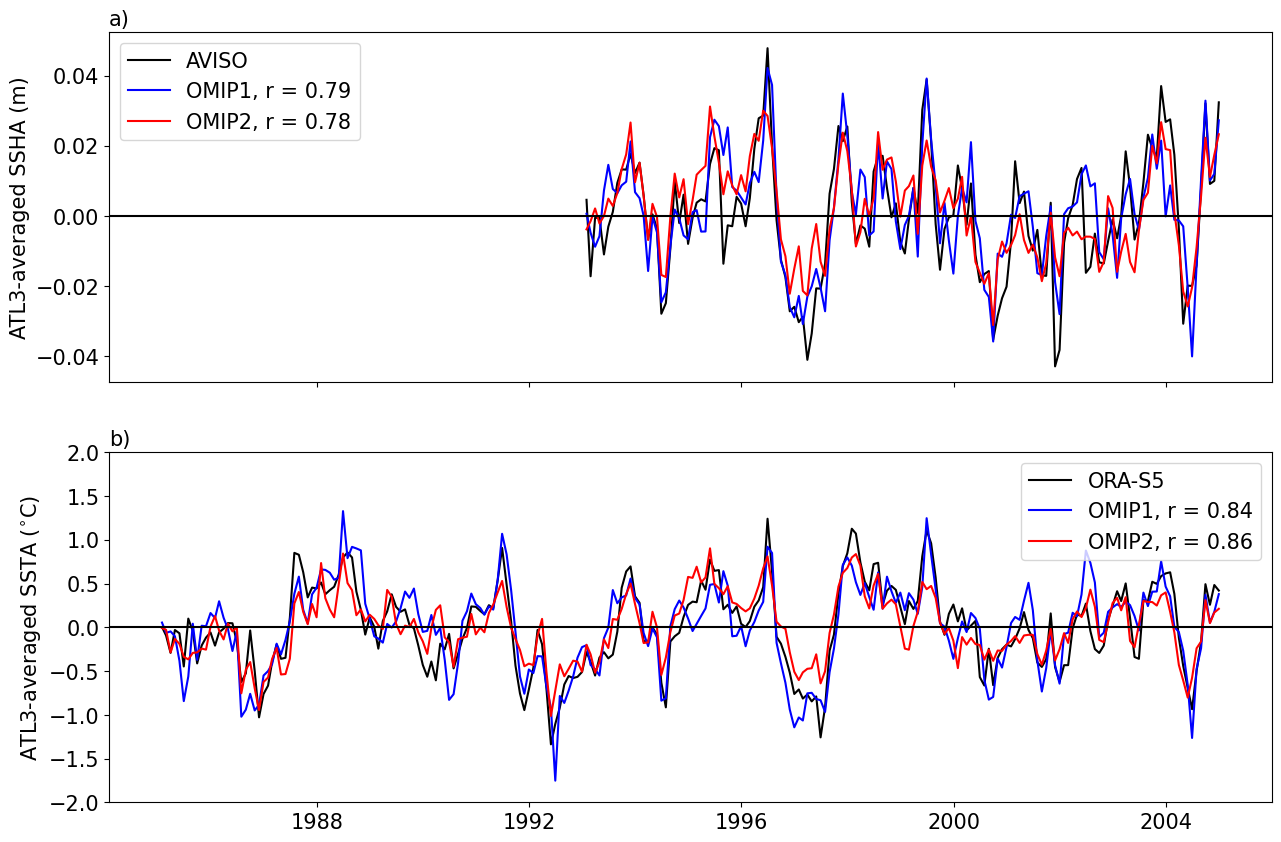

In [39]:
f,ax = plt.subplots(2,1,figsize=[15,10],sharex=True)
ftz=15
ax=ax.ravel()


ax[0].plot(zosa_eq_omip1_atl3_for_aviso.time,ssha_aviso_atl3_dtd,color='black',label='AVISO')
ax[0].plot(zosa_eq_omip1_atl3_for_aviso.time,
        zosa_eq_omip1_atl3_for_aviso.mean(dim='model'),color='blue',label='OMIP1, r = 0.79')
ax[0].plot(zosa_eq_omip2_atl3_for_aviso.time,
        zosa_eq_omip2_atl3_for_aviso.mean(dim='model'),color='red',label='OMIP2, r = 0.78')
ax[0].axhline(0,color='black')
#ax[0].set_ylim([-2,2])
ax[0].tick_params(labelsize=ftz)
ax[0].set_ylabel('ATL3-averaged SSHA (m)',fontsize=ftz)
ax[0].legend(fontsize=ftz)



ax[1].plot(ssta_omip1_atl3_for_oras5.time,ssta_oras5_atl3_dtd,color='black',label='ORA-S5')
ax[1].plot(ssta_omip1_atl3_for_oras5.time,
        ssta_omip1_atl3_for_oras5.ssta.mean(dim='model'),color='blue',label='OMIP1, r = 0.84')
ax[1].plot(ssta_omip1_atl3_for_oras5.time,
        ssta_omip2_atl3_for_oras5.ssta.mean(dim='model'),color='red',label='OMIP2, r = 0.86')
ax[1].axhline(0,color='black')
ax[1].set_ylim([-2,2])
ax[1].tick_params(labelsize=ftz)
ax[1].set_ylabel('ATL3-averaged SSTA ($^{\circ}$C)',fontsize=ftz)
ax[1].legend(fontsize=ftz)

ax[0].text(0,1.02,'a)',transform=ax[0].transAxes,size=ftz)
ax[1].text(0,1.02,'b)',transform=ax[1].transAxes,size=ftz)

In [40]:
std_uasa_eq_omip1_mjj_atl4 = np.sqrt(uasa_eq_omip1_mjj_atl4.var(dim='year'))
std_uasa_eq_omip2_mjj_atl4 = np.sqrt(uasa_eq_omip2_mjj_atl4.var(dim='year'))
std_uasa_eq_mom_mjj_atl4 = np.sqrt(uasa_eq_mom_mjj_atl4.var(dim='year'))
std_uasa_eq_mom025_mjj_atl4 = np.sqrt(uasa_eq_mom025_mjj_atl4.var(dim='year'))
std_uasa_eq_mom_core2_mjj_atl4 = np.sqrt(uasa_eq_mom_core2_mjj_atl4.var(dim='year'))
std_uasa_eq_mom_core2_heat_mjj_atl4 = np.sqrt(uasa_eq_mom_core2_heat_mjj_atl4.var(dim='year'))


std_zosa_eq_omip1_mjj_atl3 = np.sqrt(zosa_eq_omip1_mjj_atl3.var(dim='year'))
std_zosa_eq_omip2_mjj_atl3 = np.sqrt(zosa_eq_omip2_mjj_atl3.var(dim='year'))
std_zosa_eq_mom_mjj_atl3 = np.sqrt(zosa_eq_mom_mjj_atl3.var(dim='year'))
std_zosa_eq_mom025_mjj_atl3 = np.sqrt(zosa_eq_mom025_mjj_atl3.var(dim='year'))
std_zosa_eq_mom_core2_mjj_atl3 = np.sqrt(zosa_eq_mom_core2_mjj_atl3.var(dim='year'))
std_zosa_eq_mom_core2_heat_mjj_atl3 = np.sqrt(zosa_eq_mom_core2_heat_mjj_atl3.var(dim='year'))

## MLD

In [41]:

mld_eq_omip1_mjj = mld_eq_omip1.mld.sel(time=is_mjj(mld_eq_omip1.mld['time.month'])).mean(dim='time')
mld_eq_omip2_mjj = mld_eq_omip2.mld.sel(time=is_mjj(mld_eq_omip2.mld['time.month'])).mean(dim='time')

mld_eq_omip1_mjj_atl3 = mld_eq_omip1_mjj.where(mld_eq_omip1_mjj.lon>-20 &
                                                         (mld_eq_omip1_mjj.lon<0)).mean(dim='lon')
mld_eq_omip2_mjj_atl3 = mld_eq_omip2_mjj.where(mld_eq_omip2_mjj.lon>-20 &
                                                         (mld_eq_omip2_mjj.lon<0)).mean(dim='lon')

## tempa

In [42]:
std_thetao_eq_omip1_mjj = thetao_eq_omip1.tempa.sel(time=is_mjj(
    thetao_eq_omip1.tempa['time.month'])).groupby('time.year').mean()

std_thetao_eq_omip2_mjj = thetao_eq_omip2.tempa.sel(time=is_mjj(
    thetao_eq_omip2.tempa['time.month'])).groupby('time.year').mean()

In [43]:
std_thetao_eq_omip1_mjj_ens = np.sqrt(std_thetao_eq_omip1_mjj.var(dim='year'))
std_thetao_eq_omip2_mjj_ens = np.sqrt(std_thetao_eq_omip2_mjj.var(dim='year'))

## dT/dz

In [44]:
dtdz_eq_omip1_mjj = dtdz_eq_omip1.dtdz.sel(time=is_mjj(dtdz_eq_omip1.dtdz['time.month'])).mean(dim='time')
dtdz_eq_omip2_mjj = dtdz_eq_omip2.dtdz.sel(time=is_mjj(dtdz_eq_omip2.dtdz['time.month'])).mean(dim='time')

dtdz_max_eq_omip1_mjj = dtdz_eq_omip1.dtdz_max.sel(time=is_mjj(
    dtdz_eq_omip1.dtdz_max['time.month'])).mean(dim='time')
dtdz_max_eq_omip2_mjj = dtdz_eq_omip2.dtdz_max.sel(time=is_mjj(
    dtdz_eq_omip2.dtdz_max['time.month'])).mean(dim='time')


In [45]:
dtdz_max_eq_omip1_mjj_atl3 = dtdz_max_eq_omip1_mjj.where((dtdz_max_eq_omip1_mjj.lon>-20) &
                                                         (dtdz_max_eq_omip1_mjj.lon<0))
dtdz_max_eq_omip1_mjj_atl3_mean = dtdz_max_eq_omip1_mjj_atl3.mean(dim='lon')

dtdz_max_eq_omip1_mjj_atl4 = dtdz_max_eq_omip1_mjj.where((dtdz_max_eq_omip1_mjj.lon>-40 )&
                                                         (dtdz_max_eq_omip1_mjj.lon<-20))
dtdz_max_eq_omip1_mjj_atl4_mean = dtdz_max_eq_omip1_mjj_atl4.mean(dim='lon')

dtdz_max_eq_omip2_mjj_atl3 = dtdz_max_eq_omip2_mjj.where((dtdz_max_eq_omip2_mjj.lon>-20) &
                                                         (dtdz_max_eq_omip2_mjj.lon<0))
dtdz_max_eq_omip2_mjj_atl3_mean = dtdz_max_eq_omip2_mjj_atl3.mean(dim='lon')

dtdz_max_eq_omip2_mjj_atl4 = dtdz_max_eq_omip2_mjj.where((dtdz_max_eq_omip2_mjj.lon>-40) &
                                                         (dtdz_max_eq_omip2_mjj.lon<-20))
dtdz_max_eq_omip2_mjj_atl4_mean = dtdz_max_eq_omip2_mjj_atl4.mean(dim='lon')

dtdz_max_eq_omip1_mjj_tilt = dtdz_max_eq_omip1_mjj_atl4_mean - dtdz_max_eq_omip1_mjj_atl3_mean
dtdz_max_eq_omip2_mjj_tilt = dtdz_max_eq_omip2_mjj_atl4_mean - dtdz_max_eq_omip2_mjj_atl3_mean



### compute amplitude of the dT/dz around +/- 10m of the dT/dz max

In [46]:
dtdz_eq_omip1_mjj_dtdzmax_mean_atl3 = dtdz_eq_omip1_mjj.where((dtdz_eq_omip1_mjj.lon<0)&
                                                         (dtdz_eq_omip1_mjj.lon>-20)&
                                                         (dtdz_eq_omip1_mjj.depth<dtdz_max_eq_omip1_mjj+10) &
                                                         (dtdz_eq_omip1_mjj.depth>dtdz_max_eq_omip1_mjj-10))


dtdz_eq_omip2_mjj_dtdzmax_mean_atl3 = dtdz_eq_omip2_mjj.where((dtdz_eq_omip2_mjj.lon<0)&
                                                         (dtdz_eq_omip2_mjj.lon>-20)&
                                                         (dtdz_eq_omip2_mjj.depth<dtdz_max_eq_omip2_mjj+10) &
                                                         (dtdz_eq_omip2_mjj.depth>dtdz_max_eq_omip2_mjj-10))

In [47]:
dtdz_eq_omip1_mjj_dtdzmax_mean_atl3_mean = dtdz_eq_omip1_mjj_dtdzmax_mean_atl3.mean(dim='lon').mean(dim='depth')
dtdz_eq_omip2_mjj_dtdzmax_mean_atl3_mean = dtdz_eq_omip2_mjj_dtdzmax_mean_atl3.mean(dim='lon').mean(dim='depth')

In [48]:
std_thetao_eq_omip1_mjj_ens_mean_atl3 = std_thetao_eq_omip1_mjj_ens.where((std_thetao_eq_omip1_mjj_ens.lon<0)&
                                                         (std_thetao_eq_omip1_mjj_ens.lon>-20)&
                                                         (std_thetao_eq_omip1_mjj_ens.depth<dtdz_max_eq_omip1_mjj+10) &
                                                         (std_thetao_eq_omip1_mjj_ens.depth>dtdz_max_eq_omip1_mjj-10))


std_thetao_eq_omip2_mjj_ens_mean_atl3 = std_thetao_eq_omip2_mjj_ens.where((std_thetao_eq_omip2_mjj_ens.lon<0)&
                                                         (std_thetao_eq_omip2_mjj_ens.lon>-20)&
                                                         (std_thetao_eq_omip2_mjj_ens.depth<dtdz_max_eq_omip2_mjj+10) &
                                                         (std_thetao_eq_omip2_mjj_ens.depth>dtdz_max_eq_omip2_mjj-10))
std_thetao_eq_omip1_mjj_ens_mean_atl3_mean = std_thetao_eq_omip1_mjj_ens_mean_atl3.mean(
    dim='lon').mean(dim='depth')

std_thetao_eq_omip2_mjj_ens_mean_atl3_mean = std_thetao_eq_omip2_mjj_ens_mean_atl3.mean(
    dim='lon').mean(dim='depth')

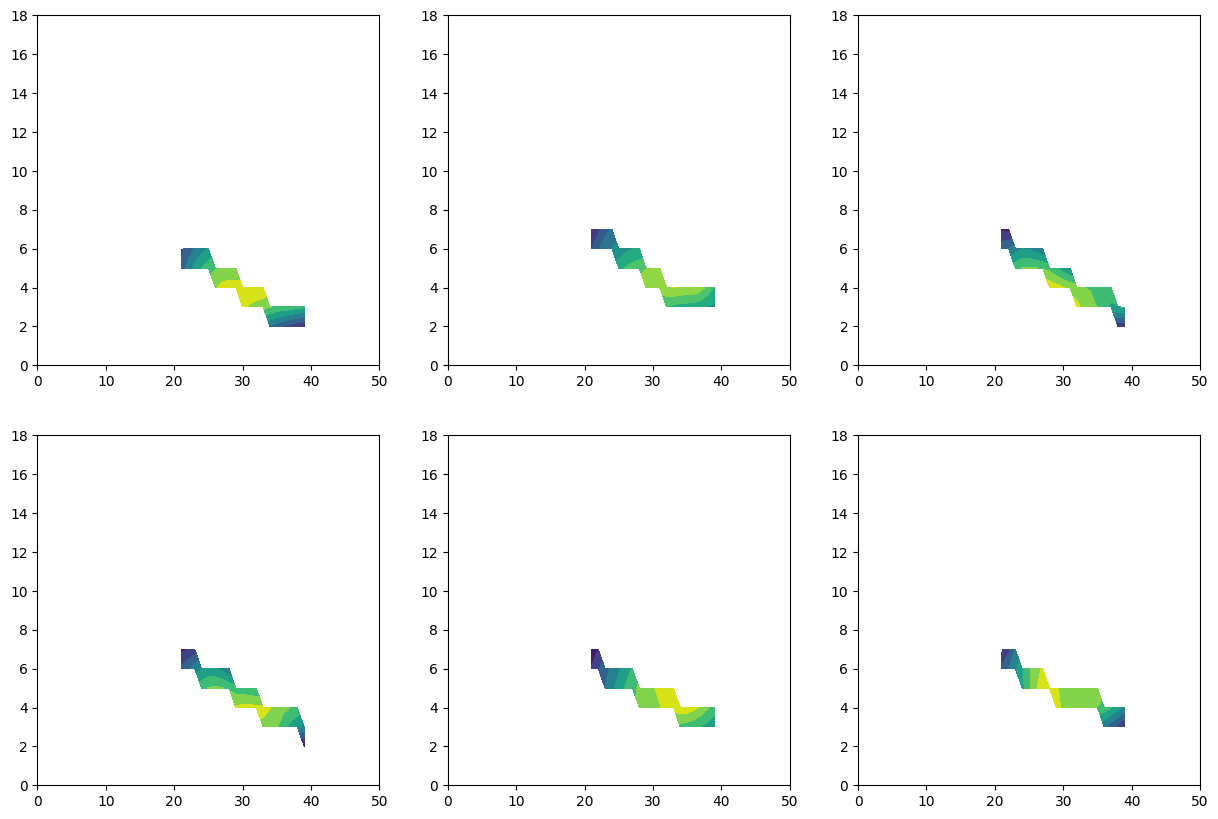

In [49]:
f,ax = plt.subplots(2,3,figsize=[15,10])
ax=ax.ravel()
for i in range(std_thetao_eq_omip1_mjj_ens_mean_atl3.shape[0]):
    ax[i].contourf(std_thetao_eq_omip1_mjj_ens_mean_atl3[i,:,:])

## SSTa

In [50]:
## OMIP1 ##
ssta_omip1_atl_all_mjj = ssta_omip1_atl_all.ssta.sel(time=is_mjj(ssta_omip1_atl_all.ssta['time.month'])).groupby('time.year').mean()
ssta_omip1_atl3_all_mjj = Atools.data_sub(ssta_omip1_atl_all_mjj,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(ssta_omip1_atl_all_mjj,-20,0,-3,3).lat))).mean(('lon','lat'))
std_ssta_omip1_atl3_all_mjj = ssta_omip1_atl3_all_mjj.std(dim='year')
var_ssta_omip1_atl3_all_mjj = ssta_omip1_atl3_all_mjj.var(dim='year')
## OMIP2 ##

ssta_omip2_atl_all_mjj = ssta_omip2_atl_all.ssta.sel(time=is_mjj(ssta_omip2_atl_all.ssta['time.month'])).groupby('time.year').mean()
ssta_omip2_atl3_all_mjj = Atools.data_sub(ssta_omip2_atl_all_mjj,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(ssta_omip2_atl_all_mjj,-20,0,-3,3).lat))).mean(('lon','lat'))
std_ssta_omip2_atl3_all_mjj = ssta_omip2_atl3_all_mjj.std(dim='year')
var_ssta_omip2_atl3_all_mjj = ssta_omip2_atl3_all_mjj.var(dim='year')

In [51]:
std_ens_mean_omip1 = np.sqrt(var_ssta_omip1_atl3_all_mjj.mean(dim='model'))
err_ens_mean_omip1 = np.sqrt(var_ssta_omip1_atl3_all_mjj).std(dim='model')

std_ens_mean_omip2 = np.sqrt(var_ssta_omip2_atl3_all_mjj.mean(dim='model'))
err_ens_mean_omip2 = np.sqrt(var_ssta_omip2_atl3_all_mjj).std(dim='model')

In [52]:
dtdz_eq_omip1_mjj_dtdzmax_mean_atl3_mean_ens = dtdz_eq_omip1_mjj_dtdzmax_mean_atl3_mean.mean(dim='model')

# Figure 11

In [53]:
nb_vertical_omip1 = [50,50,75,75,61,70]
nb_vertical_omip2 = [50,50,50,50,75,61,70]

num_omip1 = np.arange(0,std_ssta_omip1_atl3_all_mjj.model.shape[0],1)
num_omip2 = np.arange(std_ssta_omip1_atl3_all_mjj.model.shape[0],std_ssta_omip1_atl3_all_mjj.model.shape[0]+
                      std_ssta_omip2_atl3_all_mjj.model.shape[0],1)

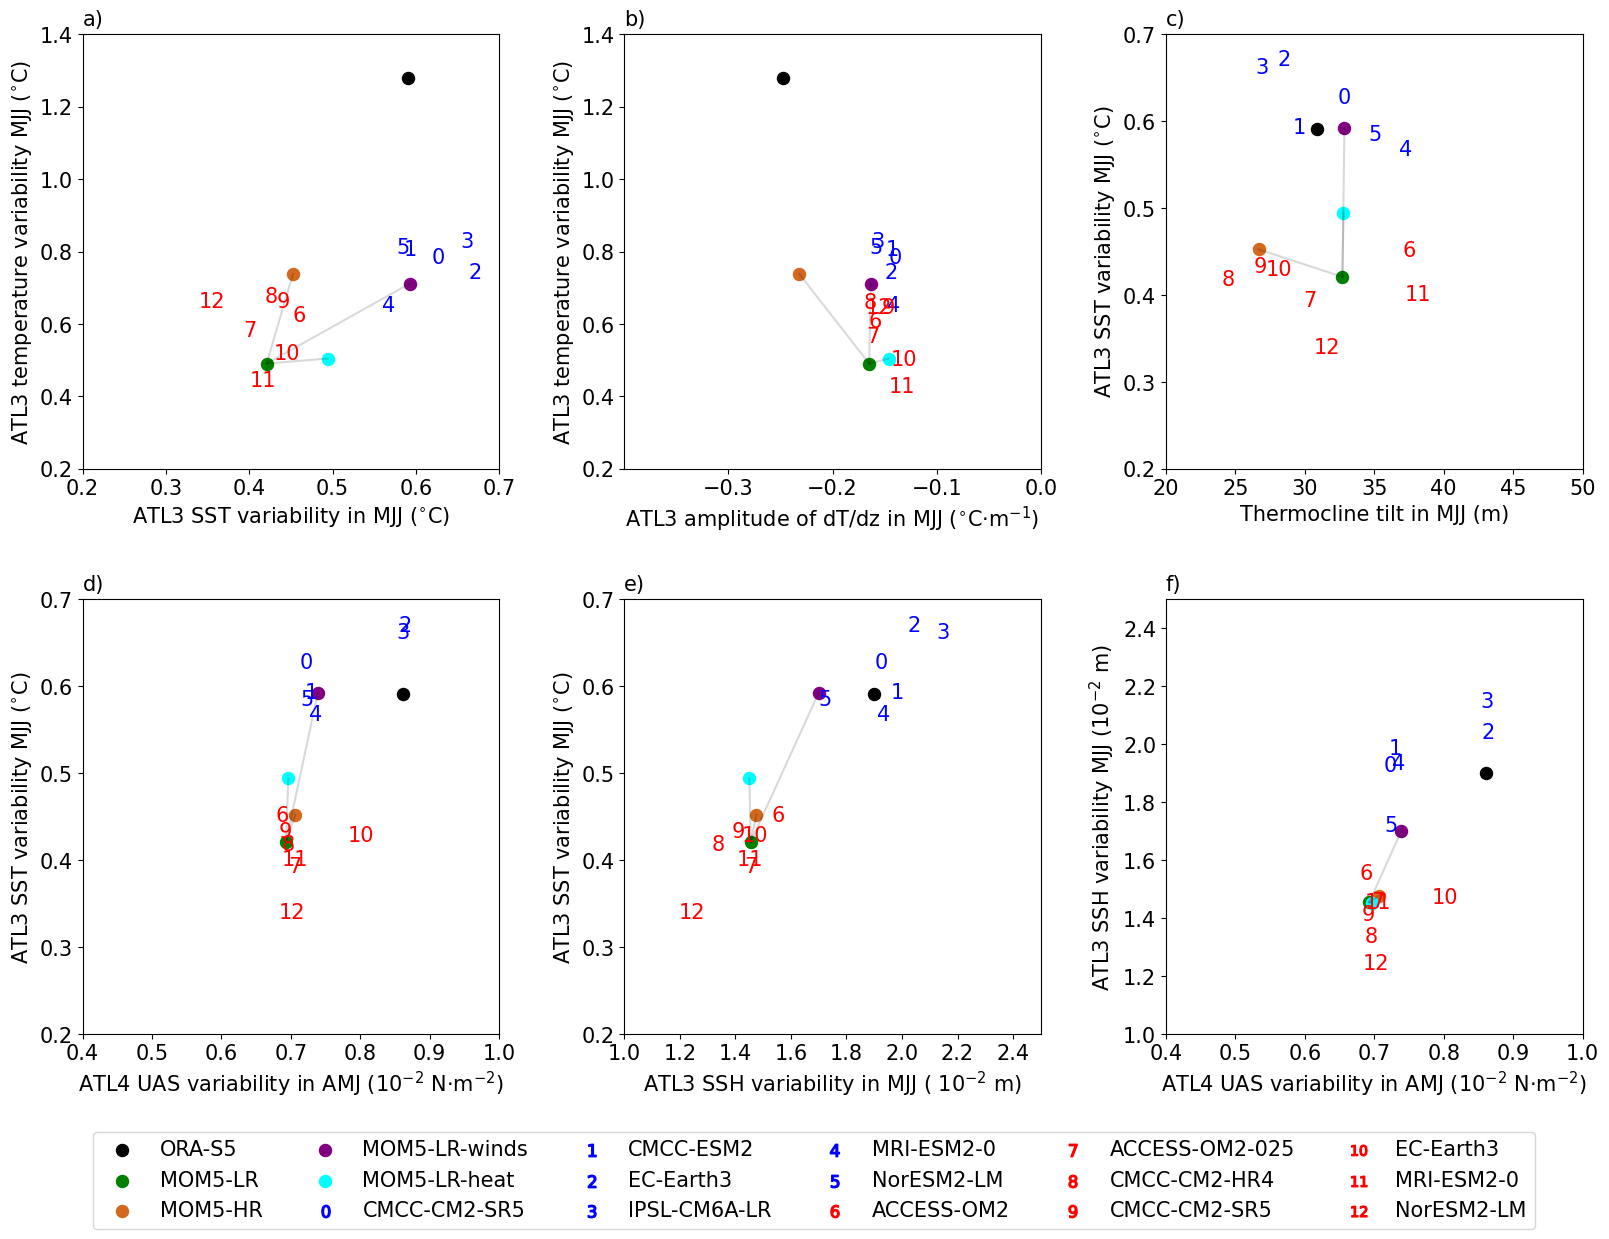

In [54]:
f,ax = plt.subplots(2,3,figsize=[15,10])
f.patch.set_facecolor('white')
ax=ax.ravel()
ftz = 15
s = 75
alpha=0.15
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.3, wspace=0.3)

trans0 = transforms.blended_transform_factory(ax[0].transData,ax[0].transData)




ax[0].scatter(std_ssta_oras5_atl3_dtd_mjj,
              std_thetaoa_eq_oras5_mjj_mean_atl3_mean,color='black',s=s,label='ORA-S5')
ax[0].scatter(std_ssta_eq_mom_mjj_atl3,
              std_tempa_eq_mom_mjj_mean_atl3,color='green',s=s,label='MOM5-LR')


ax[0].scatter(std_ssta_eq_mom025_mjj_atl3,
              std_tempa_eq_mom025_mjj_mean_atl3,color='chocolate',s=s,label='MOM5-HR')

ax[0].scatter(std_ssta_eq_mom_core2_mjj_atl3,
              std_tempa_eq_mom_core2_mjj_mean_atl3,color='purple',s=s,label='MOM5-LR-winds')

ax[0].scatter(std_ssta_eq_mom_core2_heat_mjj_atl3,
              std_tempa_eq_mom_core2_heat_mjj_mean_atl3,color='cyan',s=s,label='MOM5-LR-heat')

ax[0].plot((std_ssta_eq_mom_mjj_atl3,std_ssta_eq_mom_core2_mjj_atl3),
          (std_tempa_eq_mom_mjj_mean_atl3,
            std_tempa_eq_mom_core2_mjj_mean_atl3),color='black',
            alpha=alpha)

ax[0].plot((std_ssta_eq_mom_mjj_atl3,std_ssta_eq_mom025_mjj_atl3),
          (std_tempa_eq_mom_mjj_mean_atl3,
            std_tempa_eq_mom025_mjj_mean_atl3),color='black',
            alpha=alpha)

ax[0].plot((std_ssta_eq_mom_mjj_atl3,std_ssta_eq_mom_core2_heat_mjj_atl3),
          (std_tempa_eq_mom_mjj_mean_atl3,
            std_tempa_eq_mom_core2_heat_mjj_mean_atl3),color='black',
            alpha=alpha)



for i in range(std_ssta_omip1_atl3_all_mjj.model.shape[0]):
    ax[0].text(std_ssta_omip1_atl3_all_mjj[i],
               std_thetao_eq_omip1_mjj_ens_mean_atl3_mean[i],
               str(num_omip1[i]),transform=trans0,ha='center',va='center',fontsize=ftz,
               color='blue')
    
    ax[0].scatter(-10, -10,marker=r"$ {} $".format(num_omip1[i]),
                  label=std_ssta_omip1_atl3_all_mjj.model[i].values,
               color='blue',s=80)

for i in range(std_ssta_omip2_atl3_all_mjj.model.shape[0]):   
    ax[0].text(std_ssta_omip2_atl3_all_mjj[i],
               std_thetao_eq_omip2_mjj_ens_mean_atl3_mean[i],
               str(num_omip2[i]),transform=trans0,color='red',fontsize=ftz)
    if num_omip2[i]<10:
        ax[0].scatter(-10, -10,marker=r"$ {} $".format(num_omip2[i]),
                  label=std_ssta_omip2_atl3_all_mjj.model[i].values,
               color='red',s=80)
    else:
        ax[0].scatter(-10, -10,marker=r"$ {} $".format(num_omip2[i]),
                  label=std_ssta_omip2_atl3_all_mjj.model[i].values,
               color='red',s=150)
ax[0].set_ylabel('ATL3 temperature variability MJJ ($^{\circ}$C)',fontsize=ftz)
ax[0].set_xlabel('ATL3 SST variability in MJJ ($^{\circ}$C)',fontsize=ftz)


#ax[0].axvline(std_ssta_hd_atl3_dtd_mjj,color='grey',linestyle='--')
#ax[0].text(std_ssta_hd_atl3_dtd_mjj,1,
#           '$\sigma_{HadI-SSTA}$ = '+str(np.round(std_ssta_hd_atl3_dtd_mjj.values,2))+'$^{\circ}$C',
#           fontsize=ftz,ha='center',
#          va='center',rotation=90)
ax[0].tick_params(labelsize=ftz)
ax[0].set_xlim([0.2,0.7])
ax[0].set_ylim([0.2,1.4])
#ax[0].legend(fontsize=10)

ax[0].legend(bbox_to_anchor=(0,-1.5),ncol=6,loc='upper left',fontsize=ftz)




trans1 = transforms.blended_transform_factory(ax[1].transData,ax[1].transData)



ax[1].scatter(dtdz_eq_oras5_mjj_dtdzmax_mean_atl3_mean,
              std_thetaoa_eq_oras5_mjj_mean_atl3_mean,color='black',s=s)

ax[1].scatter(dtdz_eq_mom_mjj_dtdzmax_mean_atl3_mean,
              std_tempa_eq_mom_mjj_mean_atl3,color='green',s=s)

ax[1].scatter(dtdz_eq_mom025_mjj_dtdzmax_mean_atl3_mean,
              std_tempa_eq_mom025_mjj_mean_atl3,color='chocolate',s=s)

ax[1].scatter(dtdz_eq_mom_core2_mjj_dtdzmax_mean_atl3_mean,
              std_tempa_eq_mom_core2_mjj_mean_atl3,color='purple',s=s)

ax[1].scatter(dtdz_eq_mom_core2_heat_mjj_dtdzmax_mean_atl3_mean,
              std_tempa_eq_mom_core2_heat_mjj_mean_atl3,color='cyan',s=s)

ax[1].plot((dtdz_eq_mom_mjj_dtdzmax_mean_atl3_mean,dtdz_eq_mom_core2_mjj_dtdzmax_mean_atl3_mean),
          (std_tempa_eq_mom_mjj_mean_atl3,
            std_tempa_eq_mom_core2_mjj_mean_atl3),color='black',
            alpha=alpha)


ax[1].plot((dtdz_eq_mom_mjj_dtdzmax_mean_atl3_mean,dtdz_eq_mom025_mjj_dtdzmax_mean_atl3_mean),
          (std_tempa_eq_mom_mjj_mean_atl3,
            std_tempa_eq_mom025_mjj_mean_atl3),color='black',
            alpha=alpha)


ax[1].plot((dtdz_eq_mom_mjj_dtdzmax_mean_atl3_mean,dtdz_eq_mom_core2_heat_mjj_dtdzmax_mean_atl3_mean),
          (std_tempa_eq_mom_mjj_mean_atl3,
            std_tempa_eq_mom_core2_heat_mjj_mean_atl3),color='black',
            alpha=alpha)




for i in range(std_ssta_omip1_atl3_all_mjj.model.shape[0]):
    ax[1].text(dtdz_eq_omip1_mjj_dtdzmax_mean_atl3_mean[i],std_thetao_eq_omip1_mjj_ens_mean_atl3_mean[i],
               str(num_omip1[i]),
               transform=trans1,ha='center',va='center',fontsize=ftz,color='blue')
    
for i in range(std_ssta_omip2_atl3_all_mjj.model.shape[0]):   
    ax[1].text(dtdz_eq_omip2_mjj_dtdzmax_mean_atl3_mean[i],std_thetao_eq_omip2_mjj_ens_mean_atl3_mean[i],
               str(num_omip2[i]),
               transform=trans1,ha='center',va='center',fontsize=ftz,color='red')
ax[1].set_xlabel('ATL3 amplitude of dT/dz in MJJ ($^{\circ}$C$\cdot$m$^{-1}$)',fontsize=ftz)
ax[1].set_ylabel('ATL3 temperature variability MJJ ($^{\circ}$C)',fontsize=ftz)
ax[1].tick_params(labelsize=ftz)
ax[1].set_xticks([-0.30,-0.2,-0.1,0])
ax[1].set_xlim([-0.40,0])
ax[1].set_ylim([0.2,1.4])







trans2 = transforms.blended_transform_factory(ax[2].transData,ax[2].transData)
ax[2].scatter(dtdz_max_eq_oras5_mjj_tilt,
              std_ssta_oras5_atl3_dtd_mjj,color='black',s=s)

ax[2].scatter(dtdz_max_eq_mom_mjj_tilt,std_ssta_eq_mom_mjj_atl3,color='green',s=s)
ax[2].scatter(dtdz_max_eq_mom025_mjj_tilt,std_ssta_eq_mom025_mjj_atl3,color='chocolate',s=s)
ax[2].scatter(dtdz_max_eq_mom_core2_mjj_tilt,std_ssta_eq_mom_core2_mjj_atl3,color='purple',s=s)
ax[2].scatter(dtdz_max_eq_mom_core2_heat_mjj_tilt,std_ssta_eq_mom_core2_heat_mjj_atl3,color='cyan',s=s)


ax[2].plot((dtdz_max_eq_mom_mjj_tilt,dtdz_max_eq_mom025_mjj_tilt),
          (std_ssta_eq_mom_mjj_atl3,
            std_ssta_eq_mom025_mjj_atl3),color='black',
            alpha=alpha)

ax[2].plot((dtdz_max_eq_mom_mjj_tilt,dtdz_max_eq_mom_core2_mjj_tilt),
          (std_ssta_eq_mom_mjj_atl3,
            std_ssta_eq_mom_core2_mjj_atl3),color='black',
            alpha=alpha)

ax[2].plot((dtdz_max_eq_mom_mjj_tilt,dtdz_max_eq_mom_core2_heat_mjj_tilt),
          (std_ssta_eq_mom_mjj_atl3,
            std_ssta_eq_mom_core2_heat_mjj_atl3),color='black',
            alpha=alpha)


for i in range(std_ssta_omip1_atl3_all_mjj.model.shape[0]):
    ax[2].text(dtdz_max_eq_omip1_mjj_tilt[i],std_ssta_omip1_atl3_all_mjj[i],
               str(num_omip1[i]),
               transform=trans2,ha='center',va='center',fontsize=ftz,color='blue')
    
for i in range(std_ssta_omip2_atl3_all_mjj.model.shape[0]):   
    ax[2].text(dtdz_max_eq_omip2_mjj_tilt[i],std_ssta_omip2_atl3_all_mjj[i],
               str(num_omip2[i]),
               transform=trans2,ha='center',va='center',fontsize=ftz,color='red')
ax[2].set_xlabel('Thermocline tilt in MJJ (m)',fontsize=ftz)
ax[2].set_ylabel('ATL3 SST variability MJJ ($^{\circ}$C)',fontsize=ftz)
ax[2].tick_params(labelsize=ftz)

ax[2].set_xlim([20,50])
ax[2].set_ylim([0.2,0.7])






trans3 = transforms.blended_transform_factory(ax[3].transData,ax[3].transData)



ax[3].scatter(std_uasa_oras5_atl4_dtd_mjj*100,std_ssta_oras5_atl3_dtd_mjj,color='black',s=s)
ax[3].scatter(std_uasa_eq_mom_mjj_atl4*100,std_ssta_eq_mom_mjj_atl3,color='green',s=s)
ax[3].scatter(std_uasa_eq_mom025_mjj_atl4*100,std_ssta_eq_mom025_mjj_atl3,color='chocolate',s=s)
ax[3].scatter(std_uasa_eq_mom_core2_mjj_atl4*100,std_ssta_eq_mom_core2_mjj_atl3,color='purple',s=s)
ax[3].scatter(std_uasa_eq_mom_core2_heat_mjj_atl4*100,std_ssta_eq_mom_core2_heat_mjj_atl3,color='cyan',s=s)


ax[3].plot((std_uasa_eq_mom_mjj_atl4*100,std_uasa_eq_mom025_mjj_atl4*100),
          (std_ssta_eq_mom_mjj_atl3,
            std_ssta_eq_mom025_mjj_atl3),color='black',
            alpha=alpha)

ax[3].plot((std_uasa_eq_mom_mjj_atl4*100,std_uasa_eq_mom_core2_mjj_atl4*100),
          (std_ssta_eq_mom_mjj_atl3,
            std_ssta_eq_mom_core2_mjj_atl3),color='black',
            alpha=alpha)

ax[3].plot((std_uasa_eq_mom_mjj_atl4*100,std_uasa_eq_mom_core2_heat_mjj_atl4*100),
          (std_ssta_eq_mom_mjj_atl3,
            std_ssta_eq_mom_core2_heat_mjj_atl3),color='black',
            alpha=alpha)


for i in range(std_ssta_omip1_atl3_all_mjj.model.shape[0]):
    ax[3].text(std_uasa_eq_omip1_mjj_atl4[i]*100,std_ssta_omip1_atl3_all_mjj[i],
               str(num_omip1[i]),
               transform=trans3,ha='center',va='center',fontsize=ftz,color='blue')
    
for i in range(std_ssta_omip2_atl3_all_mjj.model.shape[0]):   
    ax[3].text(std_uasa_eq_omip2_mjj_atl4[i]*100,std_ssta_omip2_atl3_all_mjj[i],
               str(num_omip2[i]),
               transform=trans3,ha='center',va='center',fontsize=ftz,color='red')
ax[3].set_xlabel('ATL4 UAS variability in AMJ (10$^{-2}$ N$\cdot$m$^{-2}$)',fontsize=ftz)
ax[3].set_ylabel('ATL3 SST variability MJJ ($^{\circ}$C)',fontsize=ftz)
ax[3].tick_params(labelsize=ftz)
ax[3].set_xlim([0.4,1])
ax[3].set_ylim([0.2,0.7])






trans4 = transforms.blended_transform_factory(ax[4].transData,ax[4].transData)


ax[4].scatter(std_zosa_oras5_atl3_dtd_mjj*100,std_ssta_oras5_atl3_dtd_mjj,color='black',s=s)
ax[4].scatter(std_zosa_eq_mom_mjj_atl3*100,std_ssta_eq_mom_mjj_atl3,color='green',s=s)
ax[4].scatter(std_zosa_eq_mom025_mjj_atl3*100,std_ssta_eq_mom025_mjj_atl3,color='chocolate',s=s)
ax[4].scatter(std_zosa_eq_mom_core2_mjj_atl3*100,std_ssta_eq_mom_core2_mjj_atl3,color='purple',s=s)
ax[4].scatter(std_zosa_eq_mom_core2_heat_mjj_atl3*100,std_ssta_eq_mom_core2_heat_mjj_atl3,color='cyan',s=s)


ax[4].plot((std_zosa_eq_mom_mjj_atl3*100,std_zosa_eq_mom025_mjj_atl3*100),
          (std_ssta_eq_mom_mjj_atl3,
            std_ssta_eq_mom025_mjj_atl3),color='black',
            alpha=alpha)

ax[4].plot((std_zosa_eq_mom_mjj_atl3*100,std_zosa_eq_mom_core2_mjj_atl3*100),
          (std_ssta_eq_mom_mjj_atl3,
            std_ssta_eq_mom_core2_mjj_atl3),color='black',
            alpha=alpha)

ax[4].plot((std_zosa_eq_mom_mjj_atl3*100,std_zosa_eq_mom_core2_heat_mjj_atl3*100),
          (std_ssta_eq_mom_mjj_atl3,
            std_ssta_eq_mom_core2_heat_mjj_atl3),color='black',
            alpha=alpha)


for i in range(std_ssta_omip1_atl3_all_mjj.model.shape[0]):
    ax[4].text(std_zosa_eq_omip1_mjj_atl3[i]*100,std_ssta_omip1_atl3_all_mjj[i],
               str(num_omip1[i]),
               transform=trans4,ha='center',va='center',fontsize=ftz,color='blue')
    
for i in range(std_ssta_omip2_atl3_all_mjj.model.shape[0]):   
    ax[4].text(std_zosa_eq_omip2_mjj_atl3[i]*100,std_ssta_omip2_atl3_all_mjj[i],
               str(num_omip2[i]),
               transform=trans4,ha='center',va='center',fontsize=ftz,color='red')
ax[4].set_xlabel('ATL3 SSH variability in MJJ ( 10$^{-2}$ m)',fontsize=ftz)
ax[4].set_ylabel('ATL3 SST variability MJJ ($^{\circ}$C)',fontsize=ftz)

#ax[4].axvline(std_ssha_aviso_atl3_dtd_mjj.values*100,color='grey',linestyle='--')
ax[4].tick_params(labelsize=ftz)
ax[4].set_xlim([1,2.5])
ax[4].set_ylim([0.2,0.7])
ax[4].set_xticks([1.0,1.2,1.4,1.6,1.8,2,2.2,2.4])




trans5 = transforms.blended_transform_factory(ax[5].transData,ax[5].transData)

ax[5].scatter(std_uasa_oras5_atl4_dtd_mjj*100,std_zosa_oras5_atl3_dtd_mjj*100,color='black',s=s)
ax[5].scatter(std_uasa_eq_mom_mjj_atl4*100,std_zosa_eq_mom_mjj_atl3*100,color='green',s=s)
ax[5].scatter(std_uasa_eq_mom025_mjj_atl4*100,std_zosa_eq_mom025_mjj_atl3*100,color='chocolate',s=s)
ax[5].scatter(std_uasa_eq_mom_core2_mjj_atl4*100,std_zosa_eq_mom_core2_mjj_atl3*100,color='purple',s=s)
ax[5].scatter(std_uasa_eq_mom_core2_heat_mjj_atl4*100,std_zosa_eq_mom_core2_heat_mjj_atl3*100,color='cyan',s=s)



ax[5].plot((std_uasa_eq_mom_mjj_atl4*100,std_uasa_eq_mom025_mjj_atl4*100),
          (std_zosa_eq_mom_mjj_atl3*100,
            std_zosa_eq_mom025_mjj_atl3*100),color='black',
            alpha=alpha)

ax[5].plot((std_uasa_eq_mom_mjj_atl4*100,std_uasa_eq_mom_core2_mjj_atl4*100),
          (std_zosa_eq_mom_mjj_atl3*100,
            std_zosa_eq_mom_core2_mjj_atl3*100),color='black',
            alpha=alpha)
ax[5].plot((std_uasa_eq_mom_mjj_atl4*100,std_uasa_eq_mom_core2_heat_mjj_atl4*100),
          (std_zosa_eq_mom_mjj_atl3*100,
            std_zosa_eq_mom_core2_heat_mjj_atl3*100),color='black',
            alpha=alpha)


for i in range(std_ssta_omip1_atl3_all_mjj.model.shape[0]):
    ax[5].text(std_uasa_eq_omip1_mjj_atl4[i]*100,std_zosa_eq_omip1_mjj_atl3[i]*100,
               str(num_omip1[i]),
               transform=trans5,ha='center',va='center',fontsize=ftz,color='blue')
    
for i in range(std_ssta_omip2_atl3_all_mjj.model.shape[0]):   
    ax[5].text(std_uasa_eq_omip2_mjj_atl4[i]*100,std_zosa_eq_omip2_mjj_atl3[i]*100,
               str(num_omip2[i]),
               transform=trans5,ha='center',va='center',fontsize=ftz,color='red')
ax[5].set_xlabel('ATL4 UAS variability in AMJ (10$^{-2}$ N$\cdot$m$^{-2}$)',fontsize=ftz)
ax[5].set_ylabel('ATL3 SSH variability MJJ (10$^{-2}$ m)',fontsize=ftz)
#ax[5].axhline(std_ssha_aviso_atl3_dtd_mjj.values*100,color='grey',linestyle='--')

ax[5].tick_params(labelsize=ftz)
ax[5].set_ylim([1,2.5])

ax[5].set_xlim([0.4,1])


ax[0].text(0,1.02,'a)',transform=ax[0].transAxes,size=ftz)
ax[1].text(0,1.02,'b)',transform=ax[1].transAxes,size=ftz)
ax[2].text(0,1.02,'c)',transform=ax[2].transAxes,size=ftz)
ax[3].text(0,1.02,'d)',transform=ax[3].transAxes,size=ftz)
ax[4].text(0,1.02,'e)',transform=ax[4].transAxes,size=ftz)
ax[5].text(0,1.02,'f)',transform=ax[5].transAxes,size=ftz)

plt.savefig(path_fig+'figure_11.png',bbox_inches='tight',dpi=300)

In [55]:
alpha1,interp1,rval1,pval1,_ = stats.linregress(std_zosa_eq_omip1_mjj_atl3*100,std_ssta_omip1_atl3_all_mjj)

In [56]:
alpha2,interp2,rval2,pval2,_ = stats.linregress(std_zosa_eq_omip2_mjj_atl3*100,std_ssta_omip2_atl3_all_mjj)

# Values to put in the paper

In [51]:
print (' ')
print('OMIP1 ensemble MJJ SST variability =' ,np.round(std_ssta_omip1_atl3_all_mjj.mean(dim='model').values,3),
      '+/-',np.round(std_ssta_omip1_atl3_all_mjj.std(dim='model').values,3),'degC')

print('OMIP2 ensemble MJJ SST variability =' ,np.round(std_ssta_omip2_atl3_all_mjj.mean(dim='model').values,3),
      '+/-',np.round(std_ssta_omip2_atl3_all_mjj.std(dim='model').values,3),'degC')

print('ORA-S5 MJJ SST variability =',np.round(std_ssta_oras5_atl3_dtd_mjj.values,3),'degC')
print('MOM1 MJJ SST variability =',np.round(std_ssta_eq_mom_mjj_atl3.values,3),'degC')
print('MOM1-winds MJJ SST variability =',np.round(std_ssta_eq_mom_core2_mjj_atl3.values,3),'degC')


print (' ')
print (' ')
print('OMIP1 ensemble MJJ temp variability =' ,np.round(std_thetao_eq_omip1_mjj_ens_mean_atl3_mean.mean(dim='model').values,3),
      '+/-',np.round(std_thetao_eq_omip1_mjj_ens_mean_atl3_mean.std(dim='model').values,3),'degC')

print('OMIP2 ensemble MJJ temp variability =' ,np.round(std_thetao_eq_omip2_mjj_ens_mean_atl3_mean.mean(dim='model').values,3),
      '+/-',np.round(std_thetao_eq_omip2_mjj_ens_mean_atl3_mean.std(dim='model').values,3),'degC')
print('ORA-S5 MJJ temp variability =' ,np.round(std_thetaoa_eq_oras5_mjj_mean_atl3_mean.values,3),'degC')
print('MOM1 MJJ temp variability =' ,np.round(std_tempa_eq_mom_mjj_mean_atl3.values,3),'degC')
print('MOM1-winds MJJ temp variability =' ,np.round(std_tempa_eq_mom_core2_mjj_mean_atl3.values,3),'degC')


print (' ')
print (' ')


print('OMIP1 ensemble MJJ dTdz amp =' ,np.round(dtdz_eq_omip1_mjj_dtdzmax_mean_atl3_mean.mean(dim='model').values,3),
      '+/-',np.round(dtdz_eq_omip1_mjj_dtdzmax_mean_atl3_mean.std(dim='model').values,3),'degC/m')

print('OMIP2 ensemble MJJ dTdz amp =' ,np.round(dtdz_eq_omip2_mjj_dtdzmax_mean_atl3_mean.mean(dim='model').values,3),
      '+/-',np.round(dtdz_eq_omip2_mjj_dtdzmax_mean_atl3_mean.std(dim='model').values,3),'degC/m')
print('ORA-S5 ensemble MJJ dTdz amp =' ,np.round(dtdz_eq_oras5_mjj_dtdzmax_mean_atl3_mean.values,3),'degC/m')
print('MOM1 ensemble MJJ dTdz amp =' ,np.round(dtdz_eq_mom_mjj_dtdzmax_mean_atl3_mean.values,3),'degC/m')
print('MOM1-winds ensemble MJJ dTdz amp =' ,np.round(dtdz_eq_mom_core2_mjj_dtdzmax_mean_atl3_mean.values,3),'degC/m')



print (' ')
print (' ')

print('OMIP1 ensemble MJJ ZOS variability =' ,np.round(std_zosa_eq_omip1_mjj_atl3.mean(dim='model').values,3),
      '+/-',np.round(std_zosa_eq_omip1_mjj_atl3.std(dim='model').values,3),'m')

print('OMIP2 ensemble MJJ ZOS variability =' ,np.round(std_zosa_eq_omip2_mjj_atl3.mean(dim='model').values,3),
      '+/-',np.round(std_zosa_eq_omip2_mjj_atl3.std(dim='model').values,3),'m')

print('ORA-S5 MJJ ZOS variability =' ,np.round(std_zosa_oras5_atl3_dtd_mjj.values,3),'m')
print('MOM1 MJJ ZOS variability =' ,np.round(std_zosa_eq_mom_mjj_atl3.values,3),'m')
print('MOM1-winds MJJ ZOS variability =' ,np.round(std_zosa_eq_mom_core2_mjj_atl3.values,3),'m')

#              std_tempa_eq_mom_mjj_mean_atl3,color='green',s=s,label='MOM1')

 
OMIP1 ensemble MJJ SST variability = 0.617 +/- 0.039 degC
OMIP2 ensemble MJJ SST variability = 0.409 +/- 0.034 degC
ORA-S5 MJJ SST variability = 0.591 degC
MOM1 MJJ SST variability = 0.421 degC
MOM1-winds MJJ SST variability = 0.593 degC
 
 
OMIP1 ensemble MJJ temp variability = 0.77 +/- 0.059 degC
OMIP2 ensemble MJJ temp variability = 0.579 +/- 0.08 degC
ORA-S5 MJJ temp variability = 1.28 degC
MOM1 MJJ temp variability = 0.491 degC
MOM1-winds MJJ temp variability = 0.711 degC
 
 
OMIP1 ensemble MJJ dTdz amp = -0.147 +/- 0.008 degC/m
OMIP2 ensemble MJJ dTdz amp = -0.15 +/- 0.012 degC/m
ORA-S5 ensemble MJJ dTdz amp = -0.247 degC/m
MOM1 ensemble MJJ dTdz amp = -0.165 degC/m
MOM1-winds ensemble MJJ dTdz amp = -0.163 degC/m
 
 
OMIP1 ensemble MJJ ZOS variability = 0.02 +/- 0.001 m
OMIP2 ensemble MJJ ZOS variability = 0.014 +/- 0.001 m
ORA-S5 MJJ ZOS variability = 0.019 m
MOM1 MJJ ZOS variability = 0.015 m
MOM1-winds MJJ ZOS variability = 0.017 m


In [57]:
0.43*0.014

0.00602

In [58]:
(0.014-0.02)/0.014

-0.42857142857142855

In [59]:
dtdz_OMIPs = np.hstack((dtdz_eq_omip1_mjj_dtdzmax_mean_atl3_mean,dtdz_eq_omip2_mjj_dtdzmax_mean_atl3_mean))
stdT_OMIPs = np.hstack((std_thetao_eq_omip1_mjj_ens_mean_atl3_mean,std_thetao_eq_omip2_mjj_ens_mean_atl3_mean))

In [60]:
pearsonr(dtdz_eq_omip1_mjj_dtdzmax_mean_atl3_mean,std_thetao_eq_omip1_mjj_ens_mean_atl3_mean)


PearsonRResult(statistic=-0.5726637630859523, pvalue=0.23490511652843427)

In [61]:
pearsonr(dtdz_eq_omip2_mjj_dtdzmax_mean_atl3_mean,std_thetao_eq_omip2_mjj_ens_mean_atl3_mean)

PearsonRResult(statistic=-0.7581530269262463, pvalue=0.04825998184940578)